In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType,TimestampType,DoubleType
from pyspark.sql.functions import col, when, sum, avg, row_number 
from pyspark.sql.window import Window

In [0]:
from pyspark.sql import SparkSession 

#create session
spark = SparkSession.builder.appName("NYCcab Data Analysis").getOrCreate()

In [0]:
access_key = '*'
secret_key = '*'
encoded_secret_key = secret_key.replace("/", "%2F")
aws_bucket_name = "nyc-cab-raw-data"
mount_name = "s3dataread"

# Check if the directory is already mounted
if not any(mount.mountPoint == f"/mnt/{mount_name}" for mount in dbutils.fs.mounts()):
    # If not mounted, mount the S3 bucket
    dbutils.fs.mount(f"s3a://{access_key}:{encoded_secret_key}@{aws_bucket_name}", f"/mnt/{mount_name}")
    print("S3 bucket mounted successfully.")
else:
    print("S3 bucket is already mounted.")


S3 bucket is already mounted.


In [0]:
%fs
ls "/mnt/s3dataread"

path,name,size,modificationTime
dbfs:/mnt/s3dataread/green-cabs-raw-data/,green-cabs-raw-data/,0,0
dbfs:/mnt/s3dataread/taxi-zone-lookup/,taxi-zone-lookup/,0,0
dbfs:/mnt/s3dataread/yellow-cabs-raw-data/,yellow-cabs-raw-data/,0,0


In [0]:

green_tripdata_schema=StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("lpep_pickup_datetime", TimestampType(), True),
    StructField("lpep_dropoff_datetime", TimestampType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("PULocationID", IntegerType(), True),
    StructField("DOLocationID", IntegerType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("ehail_fee", StringType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("trip_type", IntegerType(), True),
    StructField("congestion_surcharge", DoubleType(), True)
])

In [0]:
green_tripdata_df = spark.read.schema(green_tripdata_schema) \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .load("/mnt/s3dataread/green-cabs-raw-data/green_tripdata_2023-06.csv")

green_tripdata_df.count()
green_tripdata_df.show()



+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2023-06-01 00:32:25|  2023-06-01 00:39:06|                 N|      null|          74|          42|           null|         0.84|        7.9|  1.0|    0.

In [0]:
green_tripdata_df.describe()

Out[35]: DataFrame[summary: string, VendorID: string, store_and_fwd_flag: string, RatecodeID: string, PULocationID: string, DOLocationID: string, passenger_count: string, trip_distance: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, ehail_fee: string, improvement_surcharge: string, total_amount: string, payment_type: string, trip_type: string, congestion_surcharge: string, pickup_hour: string]

#check if any null values

In [0]:
from pyspark.sql.functions import col, sum

null_counts = []


for col_name in green_tripdata_df.columns:
   
    null_count = green_tripdata_df.filter(col(col_name).isNull()).count()
   
    null_counts.append((col_name, null_count))


null_counts_df = spark.createDataFrame(null_counts, ["Column", "Null_Count"])


null_counts_df.show()


+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|            VendorID|         0|
|lpep_pickup_datetime|         0|
|lpep_dropoff_date...|         0|
|  store_and_fwd_flag|      5191|
|          RatecodeID|     65550|
|        PULocationID|         0|
|        DOLocationID|         0|
|     passenger_count|     65550|
|       trip_distance|         0|
|         fare_amount|         0|
|               extra|         0|
|             mta_tax|         0|
|          tip_amount|         0|
|        tolls_amount|         0|
|           ehail_fee|     65550|
|improvement_surch...|         0|
|        total_amount|         0|
|        payment_type|     65550|
|           trip_type|     65550|
|congestion_surcharge|      5191|
+--------------------+----------+



In [0]:
yellow_tripdata_df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/s3dataread/yellow-cabs-raw-data/yellow_tripdata_2023-06.csv")
yellow_tripdata_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2023-06-01 00:08:48|  2023-06-01 00:29:41|            1.0|          3.4|       1.0|                 N|         140|         238|           1|       21.9|  3.5|    0.5|       6.

In [0]:
# Display the schema of the DataFrame
yellow_tripdata_df.printSchema()

yellow_tripdata_df.describe()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

Out[20]: DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, stor

In [0]:
from pyspark.sql.functions import col, sum

# Define a list to store the count of null values in each column
null_counts_yellow = []

# Iterate over each column in the DataFrame
for col_name in yellow_tripdata_df.columns:
    # Count the number of null values in the column
    null_count = yellow_tripdata_df.filter(col(col_name).isNull()).count()
    # Append the column name and its null count to the list
    null_counts_yellow.append((col_name, null_count))

# Convert the list to a DataFrame
null_counts_yellow_df = spark.createDataFrame(null_counts_yellow, ["Column", "Null_Count"])

# Show the DataFrame containing null counts
null_counts_yellow_df.show()


+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|            VendorID|         0|
|tpep_pickup_datetime|         0|
|tpep_dropoff_date...|         0|
|     passenger_count|     99887|
|       trip_distance|         0|
|          RatecodeID|     99887|
|  store_and_fwd_flag|     99887|
|        PULocationID|         0|
|        DOLocationID|         0|
|        payment_type|         0|
|         fare_amount|         0|
|               extra|         0|
|             mta_tax|         0|
|          tip_amount|         0|
|        tolls_amount|         0|
|improvement_surch...|         0|
|        total_amount|         0|
|congestion_surcharge|     99887|
|         Airport_fee|     99887|
+--------------------+----------+



In [0]:


taxi_lookup_df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/s3dataread/taxi-zone-lookup/taxi_zone_lookup.csv")
taxi_lookup_df.show()


+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [0]:
taxi_lookup_df.describe()

Out[23]: DataFrame[summary: string, LocationID: string, Borough: string, Zone: string, service_zone: string]

In [0]:
from pyspark.sql.functions import col

null_counts_taxi_lookup = []

for col_name in taxi_lookup_df.columns:
    null_count = taxi_lookup_df.filter(col(col_name).isNull()).count()
    null_counts_taxi_lookup.append((col_name, null_count))

null_counts_taxi_lookup_df = spark.createDataFrame(null_counts_taxi_lookup, ["Column", "Null_Count"])

null_counts_taxi_lookup_df.show()


+------------+----------+
|      Column|Null_Count|
+------------+----------+
|  LocationID|         0|
|     Borough|         0|
|        Zone|         0|
|service_zone|         0|
+------------+----------+



+---------+--------------------+----------+
|  Borough|                Zone|trip_count|
+---------+--------------------+----------+
|Manhattan|   East Harlem North|     13221|
|Manhattan|   East Harlem South|      8148|
|   Queens|        Forest Hills|      3510|
|Manhattan|      Central Harlem|      3474|
|Manhattan| Morningside Heights|      2848|
|Manhattan|        Central Park|      2559|
|   Queens|            Elmhurst|      2459|
| Brooklyn|         Fort Greene|      2032|
| Brooklyn|Downtown Brooklyn...|      1751|
|   Queens|             Astoria|      1733|
+---------+--------------------+----------+
only showing top 10 rows



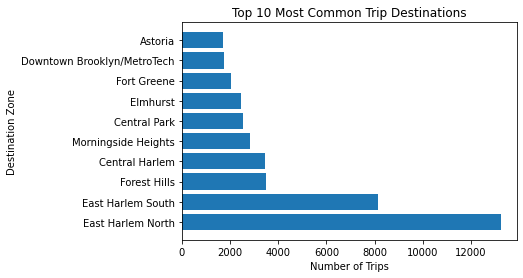

In [0]:
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt


joined_df = green_tripdata_df \
    .join(taxi_lookup_df, green_tripdata_df.PULocationID == taxi_lookup_df.LocationID, "inner") \
    .select("Borough", "Zone", "lpep_pickup_datetime")


destination_counts = joined_df.groupBy("Borough", "Zone") \
    .agg(count("*").alias("trip_count")) \
    .orderBy(col("trip_count").desc())

destination_counts.show(10)

 

top_destinations = destination_counts.limit(10).toPandas()
plt.barh(top_destinations["Zone"], top_destinations["trip_count"])
plt.xlabel("Number of Trips")
plt.ylabel("Destination Zone")
plt.title("Top 10 Most Common Trip Destinations")
plt.show()


# Calculate the average fare amount for different trip distance ranges (e.g., bins of trip distances)

+------------+------------------+
|distance_bin|  avg_total_amount|
+------------+------------------+
|         0.0|26.809294537469057|
|         0.1|17.711723076923075|
|         0.2|14.351164658634545|
|         0.3|12.203087818696885|
|         0.4| 9.702510288065838|
|         0.5| 9.798043742405845|
|         0.6|10.097771482530717|
|         0.7|10.635896700143466|
|         0.8|11.444078866296984|
|         0.9|12.012280414620829|
|         1.0| 12.44366468842729|
|         1.1| 13.07979476654695|
|         1.2|13.823709462461096|
|         1.3|14.332608520900262|
|         1.4|14.712256688638941|
|         1.5| 15.54775605214149|
|         1.6|16.190276722734644|
|         1.7|16.849277376320167|
|         1.8| 17.56764123471169|
|         1.9|18.333456193353452|
+------------+------------------+
only showing top 20 rows



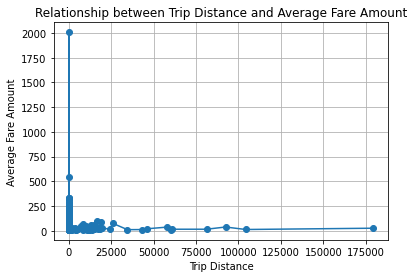

In [0]:
from pyspark.sql.functions import round


distance_fare_df = green_tripdata_df.select("trip_distance", "total_amount")


distance_fare_avg = distance_fare_df.groupBy(round("trip_distance", 1).alias("distance_bin")) \
    .agg({"total_amount": "avg"}) \
    .withColumnRenamed("avg(total_amount)", "avg_total_amount") \
    .orderBy("distance_bin")

distance_fare_avg.show()



distance_fare_pd = distance_fare_avg.toPandas()
plt.plot(distance_fare_pd["distance_bin"], distance_fare_pd["avg_total_amount"], marker='o')
plt.xlabel("Trip Distance")
plt.ylabel("Average Fare Amount")
plt.title("Relationship between Trip Distance and Average Fare Amount")
plt.grid(True)
plt.show()


distribution of trip distances for different times of the day.

+-----------+------------------+
|pickup_hour| avg_trip_distance|
+-----------+------------------+
|          0| 13.28409620991253|
|          1|3.2704772991850994|
|          2|3.2593465045592698|
|          3| 38.44914046121595|
|          4| 45.49011990407675|
|          5| 90.40190170940171|
|          6|109.08248207885302|
|          7| 3.177084855866832|
|          8| 18.22748081841432|
|          9|25.686603773584903|
|         10| 82.42951870107284|
|         11|20.523299290780145|
|         12| 63.88262876442446|
|         13|28.605427987145745|
|         14|10.021574329405865|
|         15| 8.669800137835978|
|         16| 3.128797496647292|
|         17|25.164479780960377|
|         18|11.004156685646974|
|         19|2.7839635002339764|
+-----------+------------------+
only showing top 20 rows



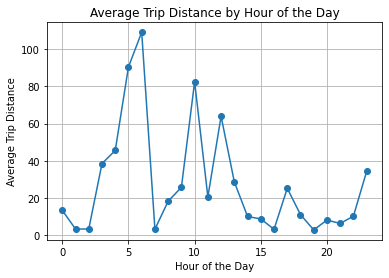

In [0]:
from pyspark.sql.functions import hour

green_tripdata_df = green_tripdata_df.withColumn("pickup_hour", hour("lpep_pickup_datetime"))

avg_trip_distance_by_hour = green_tripdata_df.groupBy("pickup_hour") \
    .agg({"trip_distance": "avg"}) \
    .withColumnRenamed("avg(trip_distance)", "avg_trip_distance") \
    .orderBy("pickup_hour")

avg_trip_distance_by_hour.show()


avg_trip_distance_pd = avg_trip_distance_by_hour.toPandas()
plt.plot(avg_trip_distance_pd["pickup_hour"], avg_trip_distance_pd["avg_trip_distance"], marker='o')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Trip Distance")
plt.title("Average Trip Distance by Hour of the Day")
plt.grid(True)
plt.show()


busiest pickup locations during different times of the day.

+-----------+-------------------+
|pickup_hour|first(PULocationID)|
+-----------+-------------------+
|          0|                 95|
|          1|                 95|
|          2|                 80|
|          3|                 80|
|          4|                129|
|          5|                 74|
|          6|                 74|
|          7|                 74|
|          8|                 74|
|          9|                 74|
|         10|                 74|
|         11|                 74|
|         12|                 74|
|         13|                 74|
|         14|                 74|
|         15|                 74|
|         16|                 74|
|         17|                 74|
|         18|                 74|
|         19|                 74|
+-----------+-------------------+
only showing top 20 rows



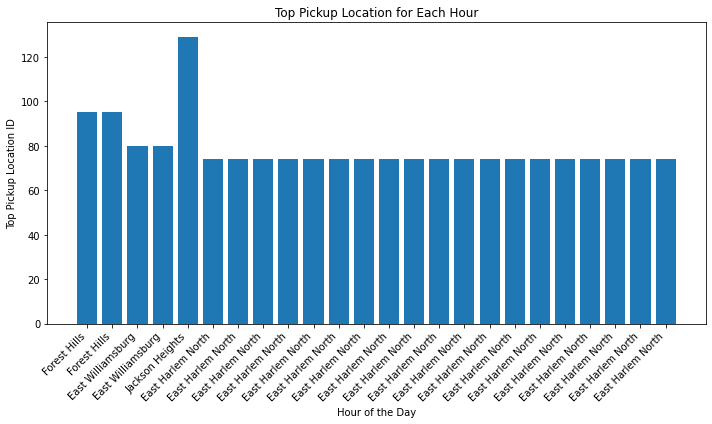

In [0]:
from pyspark.sql.functions import hour
import numpy as np


green_tripdata_df = green_tripdata_df.withColumn("pickup_hour", hour("lpep_pickup_datetime"))

pickup_location_counts = green_tripdata_df.groupBy("pickup_hour", "PULocationID") \
    .count() \
    .orderBy("pickup_hour", col("count").desc())

top_pickup_locations_by_hour = pickup_location_counts \
    .groupBy("pickup_hour") \
    .agg({"PULocationID": "first"}) \
    .orderBy("pickup_hour")


top_pickup_locations_by_hour.show()




hours = top_pickup_locations_by_hour.select("pickup_hour").rdd.flatMap(lambda x: x).collect()
top_location_ids = top_pickup_locations_by_hour.select("first(PULocationID)").rdd.flatMap(lambda x: x).collect()


top_location_names = [taxi_lookup_df.filter(col("LocationID") == loc_id).select("Zone").collect()[0]["Zone"] for loc_id in top_location_ids]


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(hours, top_location_ids, tick_label=top_location_names)


ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Top Pickup Location ID")
ax.set_title("Top Pickup Location for Each Hour")

plt.xticks(rotation=45, ha="right")


plt.tight_layout()
plt.show()


#Distribution of Trip Fares

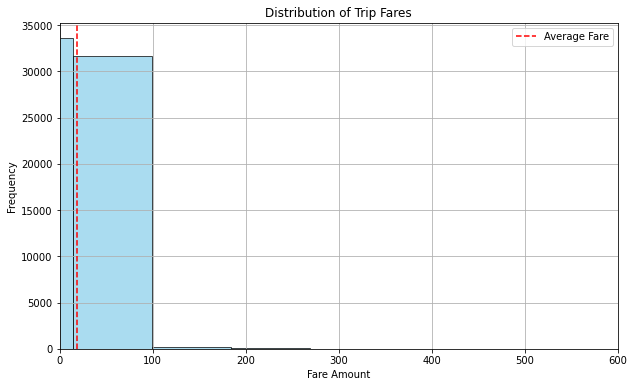

In [0]:
import matplotlib.pyplot as plt

# Calculate summary statistics for trip fares
fare_stats = green_tripdata_df.selectExpr("min(fare_amount) as min_fare", 
                                          "max(fare_amount) as max_fare", 
                                          "mean(fare_amount) as avg_fare", 
                                          "stddev(fare_amount) as stddev_fare").collect()[0]

# Extract summary statistics
min_fare = fare_stats["min_fare"]
max_fare = fare_stats["max_fare"]
avg_fare = fare_stats["avg_fare"]
stddev_fare = fare_stats["stddev_fare"]

# Define the x-axis limits
x_min = 0  # Minimum fare amount
x_max = 600  # Maximum fare amount

# Visualize the distribution of trip fares using a histogram
plt.figure(figsize=(10, 6))
plt.hist(green_tripdata_df.select("fare_amount").rdd.flatMap(lambda x: x).collect(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Trip Fares")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.axvline(x=avg_fare, color='red', linestyle='--', label='Average Fare')
plt.legend()
plt.xlim(x_min, x_max)  # Set x-axis limits
plt.grid(True)
plt.show()


In [0]:
green_tripdata_df.write.format("delta").mode("overwrite").save("/mnt/delta/green_tripdata_delta")
yellow_tripdata_df.write.format("delta").mode("overwrite").save("/mnt/delta/yellow_tripdata_delta")
taxi_lookup_df.write.format("delta").mode("overwrite").save("/mnt/delta/taxi_lookup_delta")


#Comparison of Average Trip Distance between Yellow and Green Cabs

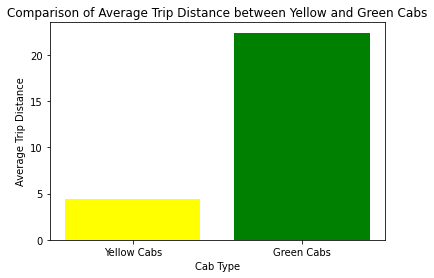

In [0]:

import matplotlib.pyplot as plt


yellow_avg_trip_distance = yellow_tripdata_df.selectExpr("avg(trip_distance) as avg_trip_distance").collect()[0]["avg_trip_distance"]

green_avg_trip_distance = green_tripdata_df.selectExpr("avg(trip_distance) as avg_trip_distance").collect()[0]["avg_trip_distance"]


categories = ["Yellow Cabs", "Green Cabs"]
avg_trip_distances = [yellow_avg_trip_distance, green_avg_trip_distance]

plt.bar(categories, avg_trip_distances, color=['yellow', 'green'])
plt.xlabel('Cab Type')
plt.ylabel('Average Trip Distance')
plt.title('Comparison of Average Trip Distance between Yellow and Green Cabs')
plt.show()


Find peak Drop off location / each hour

In [0]:
from pyspark.sql.functions import hour, col

# Add dropoff_hour column to yellow trip dataframe
yellow_tripdata_df = yellow_tripdata_df.withColumn('dropoff_hour', hour('tpep_dropoff_datetime'))

# Add dropoff_hour column to green trip dataframe
green_tripdata_df = green_tripdata_df.withColumn('dropoff_hour', hour('lpep_dropoff_datetime'))

# Select only required columns from yellow and green trip dataframes
yellow_selected_df = yellow_tripdata_df.select('dropoff_hour', 'DOLocationID')
green_selected_df = green_tripdata_df.select('dropoff_hour', 'DOLocationID')

# Union yellow and green selected dataframes
combined_dropoff_df = yellow_selected_df.union(green_selected_df)

# Group by drop-off hour and location, count drop-offs, and find the location with maximum drop-offs for each hour
peak_dropoff_locations_combined = combined_dropoff_df.groupBy('dropoff_hour', 'DOLocationID') \
    .count() \
    .orderBy(['dropoff_hour', 'count'], ascending=[True, False]) \
    .groupBy('dropoff_hour') \
    .agg({'DOLocationID': 'first'}) \
    .orderBy('dropoff_hour')  # Order the results by hour

# Print each hour and respective top drop-off location name
print("Hour\tTop Drop-off Location")
for row in peak_dropoff_locations_combined.collect():
    hour_val = row['dropoff_hour']
    top_location_id = row['first(DOLocationID)']
    top_location_name = taxi_lookup_df.filter(col('LocationID') == top_location_id).select('Zone').first()[0]
    print(f"{hour_val}\t{top_location_name}")


Hour	Top Drop-off Location
0	East Village
1	East Village
2	East Village
3	Clinton East
4	LaGuardia Airport
5	LaGuardia Airport
6	Midtown Center
7	Midtown Center
8	Midtown Center
9	Midtown Center
10	Midtown Center
11	Upper East Side South
12	Upper East Side South
13	Upper East Side South
14	Upper East Side North
15	Upper East Side North
16	Upper East Side North
17	Upper East Side North
18	Upper East Side South
19	Upper East Side North
20	Upper East Side North
21	Upper East Side North
22	Upper East Side North
23	East Village
